### Problem Statement

Your new target is:
1. 99.4% (this must be consistently shown in your last few epochs, and   not a one-time achievement)

2. Less than or equal to 15 Epochs

3. Less than 10000 Parameters (additional points for doing this in less than 8000 pts)

4. Do this in exactly 3 steps

5. Each File must have "target, result, analysis" TEXT block (either at the start or the end)


6. Explain your 3 steps using these target, results, and analysis with links to your GitHub files (Colab files moved to GitHub).


### Target:

In Iteration 2, we observed that the model was underfitting. 

The Target of this iteration is to overcome underfitting by increasing the number of parameters and also to boost the performance of the model and to reach an accuracy of 99.4% with efforts to maintain the number of parameters below 10k but with increased efforts to lower the parameters lesser then 8k .

#### Results:
1. Parameters: 7,988
2. Best Train Accuracy: 99.21
3. Best Test Accuracy: 99.11

#### Analysis:
1. As Desired we were able to overcome the problem  underfitting and we have pushed the accuracy of the model to 99.21 % 
2. The model can still be improvised to push the accuracy past 99.4% by adding more layers and increasing the number of trainable parameters and also by adding Dropout in further steps.

### Importing the Relevant Libraries 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Data Transformations 

It involves a pipeline of activities such as:
1. Converting the Image data into Tensors.
2. Normalizing the Images 
3. Data Augmentation ( Cropping , Roatating , Scaling )  

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                    #   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #   transforms.Normalize((0.1307,), (0.3081,))
                                       ])


### Dowloading the MNIST Dataset into Test and Train and applying relevant Transforms 

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Creating Data Loader to create batches of images for Training.

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## CNN Architecture

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=26, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU()
        ) # output_size = 26

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24


        # Transition  BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(28),
            nn.ReLU()
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 10


        # Transition  BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) ## output_size = 5
        self.convblock5= nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # OUTPUT BLOCK
        self.convblock6= nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=43, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(43),
            nn.ReLU()
        ) # output_size = 3
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=43, out_channels=10 , kernel_size=(1,1), padding = 0, bias=False )
        )
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
      #  x = self.dropout(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 26, 26]             234
       BatchNorm2d-2           [-1, 26, 26, 26]              52
              ReLU-3           [-1, 26, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           2,340
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 28, 10, 10]           2,520
       BatchNorm2d-9           [-1, 28, 10, 10]              56
             ReLU-10           [-1, 28, 10, 10]               0
           Conv2d-11           [-1, 15, 10, 10]             420
      BatchNorm2d-12           [-1, 15, 10, 10]              30
             ReLU-13           [-1, 15, 10, 10]               0
        MaxPool2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training and Testing 

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07832507789134979 Batch_id=468 Accuracy=88.37: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.1387, Accuracy: 9613/10000 (96.13%)

EPOCH: 1


Loss=0.0793301984667778 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0553, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.08007213473320007 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]



Test set: Average loss: 0.0514, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.10592316836118698 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]



Test set: Average loss: 0.0427, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.02000209130346775 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0370, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.026209553703665733 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]



Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.046840932220220566 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]



Test set: Average loss: 0.0425, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.0075624119490385056 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.026252932846546173 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0350, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.04969918355345726 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.042529910802841187 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]



Test set: Average loss: 0.0284, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.005183348897844553 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]



Test set: Average loss: 0.0290, Accuracy: 9897/10000 (98.97%)

EPOCH: 12


Loss=0.023692307993769646 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.94it/s]



Test set: Average loss: 0.0247, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.025188691914081573 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]



Test set: Average loss: 0.0282, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.0771007314324379 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]



Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)



## Model Evaluation Metrics : Loss and Accuracy 

Text(0.5, 1.0, 'Test Accuracy')

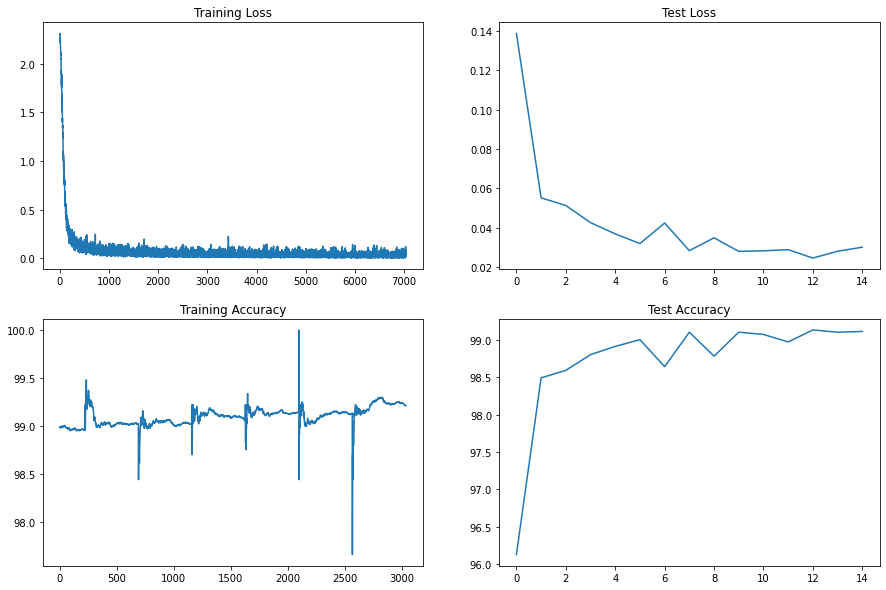

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")